In [77]:
import torchvision
!pip install qiskit ipywidgets
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
import torchvision

from tqdm import tqdm
import torch

from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

from matplotlib import pyplot as plt
%matplotlib inline



device = torch.device("cpu")
print("Running on the CPU")
    

Running on the CPU


In [78]:
np.random.seed = 2016236736

NQubits = 4
NShots = 5000
Shift = np.pi/2
SIMULATOR = qiskit.Aer.get_backend('aer_simulator')

#Cria-se uma lista dos possivels outputs para 4 Qubits
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NQubits))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [79]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expectations = np.zeros(len(counts.keys()))
        i=0
        for key in counts.keys():
            prob = counts[key]/self.shots
            expectations[i] = prob
            i=i+1 
        return expectations
    
    def run(self, i):
        t_qc = transpile(self.circuit,
                         self.backend)

        if(torch.is_tensor(i)):
             i = i.cpu().numpy()
        
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.thetas[k] : i[k].item() for k in range(self.n_qubits)}])
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        i=0
        # cálculo da energy expectation
        #print(result)
        expectations = np.zeros(len(result.keys()))
        for key in result.keys():
            prob = result[key]/self.shots
            expectations[i] = prob
            i=i+1  
        return expectations

In [80]:
simulator = qiskit.Aer.get_backend('aer_simulator')
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit=QiskitCircuit(NQubits, simulator, shots=NShots)
input =torch.tensor([np.pi/4]*NQubits)
print(input)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(input)))
circuit.circuit.draw()


tensor([0.7854, 0.7854, 0.7854, 0.7854])
Expected value for rotation [pi/4]: [0.0032 0.0026 0.0028 0.0124 0.0156 0.0156 0.0162 0.5226 0.0968 0.0852
 0.0024 0.0146 0.0006 0.0154 0.099  0.095 ]


┌───┐ ░ ┌────────────┐ ░ ┌─┐         
   q_0: ┤ H ├─░─┤ Ry(Theta0) ├─░─┤M├─────────
        ├───┤ ░ ├────────────┤ ░ └╥┘┌─┐      
   q_1: ┤ H ├─░─┤ Ry(Theta1) ├─░──╫─┤M├──────
        ├───┤ ░ ├────────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├─░─┤ Ry(Theta2) ├─░──╫──╫─┤M├───
        ├───┤ ░ ├────────────┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├─░─┤ Ry(Theta3) ├─░──╫──╫──╫─┤M├
        └───┘ ░ └────────────┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════╩══╩══╩══╩═
                                  0  1  2  3

In [81]:
previousret = 0

In [82]:
import numpy
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NQubits, SIMULATOR, shots=NShots)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result.to(device), i)
        ctx.previousret = None
        return result
    
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i.to(device)
        gradients = torch.Tensor().to(device)
        
        for k in range(NQubits):
          
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + Shift
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - Shift        
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)

            while (len(expectation_left) < 16 ):
              expectation_left=numpy.append( expectation_left, 0 )
            while (len(expectation_right) < 16 ):
              expectation_right= numpy.append( expectation_right, 0 )

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float().to(device)))
            
        result = gradients.clone()

        grad_output=grad_output.numpy()
        grad_output = grad_output[0]

        while (len(grad_output) < 16 ):
          grad_output= numpy.append( grad_output, grad_output[len(grad_output)-1] )

        grad_output=torch.tensor(grad_output)

        ret = (result.float() * grad_output.to(device).float()).T.to(device)
        ctx.previousret = ret
        return ret

In [83]:

x = torch.tensor([np.pi/4]*NQubits, requires_grad=True).to(device)

qc = TorchCircuit.apply
y1 = qc(x).to(device)
#print('y1 after quantum layer: {}'.format(y1.float()))
y1 = nn.Linear(2**NQubits,1).to(device)(y1.float()).to(device)
y1.backward()
#print('x.grad = {}'.format(x.grad))


In [84]:
x = torch.randn(3,4,5)


100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


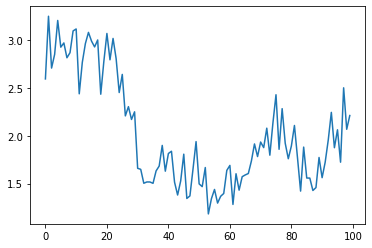

In [85]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    val = sum([(i+1)*expval[i] for i in range(len(expval))]) / 2**NQubits
#     print(val)
    return torch.abs(val - target) ** 2, expval

x = torch.tensor([-np.pi/4]*NQubits, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

In [86]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

NUM_CLASSES = 2
# Concentrating on the first 150 samples
n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][n_samples:], 
                np.where(X_test.targets == 1)[0][n_samples:])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [87]:
NUM_CIRCUITS = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_CIRCUITS*NQubits*2)
        self.qc = TorchCircuit.apply
        #self.fc3 = nn.Linear(NUM_CIRCUITS * (2**NQubits), NUM_CLASSES)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + NQubits]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*NQubits)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*NQubits)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + NQubits]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER

        x = torch.Tensor(x.float()).to(device)
        x = torch.log_softmax(x, dim=1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)


In [88]:
epochs = 15
loss_list = []
loss_func = F.nll_loss

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()        
        # Forward pass
        output = network(data).to(device)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [7%]	Loss: 3.3752


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [13%]	Loss: 3.4004


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Training [20%]	Loss: 3.4359


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Training [27%]	Loss: 3.4664


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Training [33%]	Loss: 3.4623


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [40%]	Loss: 3.4303


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [47%]	Loss: 3.3763


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [53%]	Loss: 3.3560


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [60%]	Loss: 3.3580


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [67%]	Loss: 3.3833


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [73%]	Loss: 3.3735


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [80%]	Loss: 3.3624


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Training [87%]	Loss: 3.3735


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Training [93%]	Loss: 3.3951


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]

Training [100%]	Loss: 3.3916


Text(0, 0.5, 'Cross Entropy Loss')

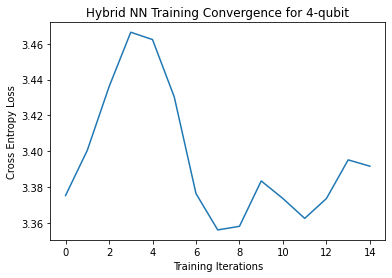

In [89]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NQubits))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')


In [90]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

100%|██████████| 1715/1715 [01:50<00:00, 15.53it/s]


In [91]:
print("Performance on test data is is: {}/{} = {}%".format(accuracy,number,100*accuracy/number))    


Performance on test data is is: 28/1715 = 1.6326530612244898%


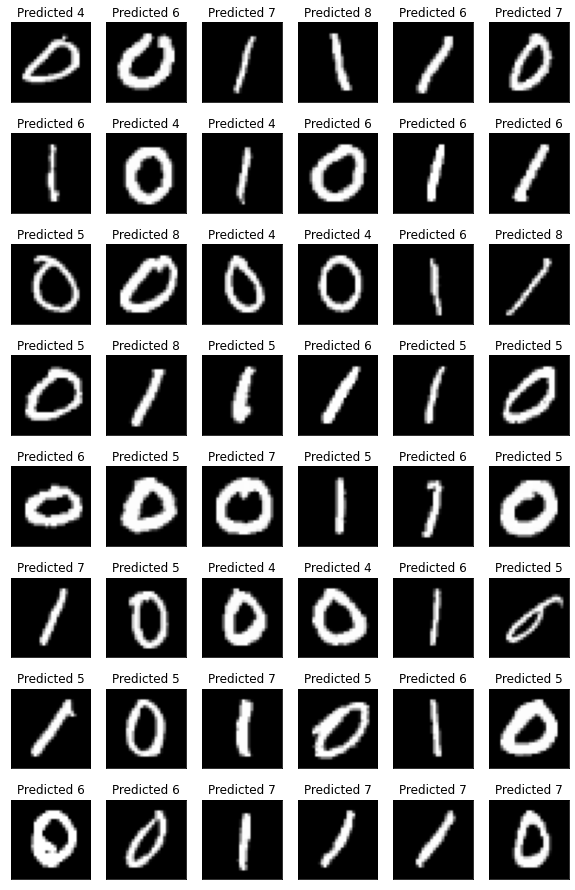

In [92]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1